In [7]:
import sys

sys.path.insert(0, '../')
import utils.common as cm
import utils.bootcampviztools as viz
import gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import seaborn as sns
sns.set_theme(style = "whitegrid", palette = "muted", context = "notebook")
import re

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

## Introduction

Due to the current changes in the Spanish car market, this project aims to establish the price of second-hand cars according to their characteristics and state of wear and tear, providing a guide on which to estimate the cost.

The data has been obtained from DataMarket, using advertisements from the main second-hand car sales websites.

In [8]:
url = cm.DATA_PATH
output = "data.csv"
gdown.download(url, output, quiet = False)

df = pd.read_csv("data.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1NtUt42nZ766HduQfyAxls1pX6deqtVh2
From (redirected): https://drive.google.com/uc?id=1NtUt42nZ766HduQfyAxls1pX6deqtVh2&confirm=t&uuid=ad64bb73-787b-4736-bc13-41828f491670
To: c:\Users\mpuch\Desktop\Portfolio_M_Puchades\ML_car_prices\src\results_notebook\data.csv
100%|██████████| 122M/122M [00:02<00:00, 58.1MB/s] 


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   vehicle_type            100000 non-null  object 
 1   make                    100000 non-null  object 
 2   model                   100000 non-null  object 
 3   version                 99842 non-null   object 
 4   fuel                    96810 non-null   object 
 5   year                    100000 non-null  int64  
 6   kms                     99189 non-null   float64
 7   power                   99709 non-null   float64
 8   doors                   0 non-null       float64
 9   shift                   98982 non-null   object 
 10  color                   0 non-null       float64
 11  photos                  100000 non-null  int64  
 12  description             55810 non-null   object 
 13  price                   100000 non-null  int64  
 14  currency             

## Feature description

<table>
<tr>
    <th>Column Name</th>
    <th>Variable Type</th>
    <th>Description</th>
    <th>Comments</th>
</tr>
<tr>
    <td>vehicle_type</td>
    <td>Categorical</td>
    <td>Type of vehicle</td>
    <td>All vehicles are cars (column to be removed)</td>
</tr>
<tr>
    <td>make</td>
    <td>Categorical</td>
    <td>Vehicle brand</td>
    <td></td>
</tr>
<tr>
    <td>model</td>
    <td>Categorical</td>
    <td>Vehicle model</td>
    <td>We need to check if the names are correctly written or if there are duplicate values</td>
</tr>
<tr>
    <td>version</td>
    <td>Text/Categorical</td>
    <td>Version of the specific car model</td>
    <td>We need to assess whether useful information can be extracted from this column</td>
</tr>
<tr>
    <td>fuel</td>
    <td>Categorical</td>
    <td>Type of fuel used by the vehicle</td>
    <td></td>
</tr>
<tr>
    <td>year</td>
    <td>Numeric</td>
    <td>Year of the vehicle (manufacturing)</td>
    <td></td>
</tr>
<tr>
    <td>kms</td>
    <td>Numeric</td>
    <td>Mileage covered by the vehicle</td>
    <td></td>
</tr>
<tr>
    <td>power</td>
    <td>Numeric</td>
    <td>Horsepower of the car</td>
    <td></td>
</tr>
<tr>
    <td>doors</td>
    <td>Numeric</td>
    <td>Number of doors</td>
    <td>100% missing values; it will be removed unless another column contains the number of doors</td>
</tr>
<tr>
    <td>shift</td>
    <td>Binary</td>
    <td>Transmission type</td>
    <td>Manual; Automatic</td>
</tr>
<tr>
    <td>color</td>
    <td>Numeric</td>
    <td>Car color</td>
    <td>100% missing values; this column will be removed</td>
</tr>
<tr>
    <td>photos</td>
    <td>Numeric</td>
    <td>Number of photos uploaded to the car listing</td>
    <td></td>
</tr>
<tr>
    <td>description</td>
    <td>Text</td>
    <td>Car listing description</td>
    <td>This column will likely be removed (44% missing values)</td>
</tr>
<tr>
    <td>price</td>
    <td>Numeric</td>
    <td>Car price</td>
    <td>This column will be our TARGET</td>
</tr>
<tr>
    <td>currency</td>
    <td>Categorical</td>
    <td>Currency type of the price</td>
    <td>Column to be removed, as it has a single value: €</td>
</tr>
<tr>
    <td>location</td>
    <td>Categorical</td>
    <td>Town where the vehicle is sold</td>
    <td>We will assess whether to use it (we have postal code)</td>
</tr>
<tr>
    <td>publish_date</td>
    <td>Datetime</td>
    <td>Listing publication date</td>
    <td></td>
</tr>
<tr>
    <td>update_date</td>
    <td>Datetime</td>
    <td>Listing update date</td>
    <td></td>
</tr>
<tr>
    <td>dealer_name</td>
    <td>Text</td>
    <td>Name of the individual seller or company</td>
    <td></td>
</tr>
<tr>
    <td>dealer_description</td>
    <td>Text</td>
    <td>Description of the selling company</td>
    <td>This column will likely be removed</td>
</tr>
<tr>
    <td>dealer_address</td>
    <td>Text</td>
    <td>Address of the company selling the vehicle</td>
    <td>This column will likely be removed</td>
</tr>
<tr>
    <td>dealer_zip_code</td>
    <td>Numeric</td>
    <td>Seller’s postal code</td>
    <td></td>
</tr>
<tr>
    <td>dealer_city</td>
    <td>Text</td>
    <td>City where the seller is located</td>
    <td></td>
</tr>
<tr>
    <td>dealer_country_code</td>
    <td>Categorical</td>
    <td>Written country code</td>
    <td>This column has a single value, so we will remove it</td>
</tr>
<tr>
    <td>dealer_is_professional</td>
    <td>Binary</td>
    <td>Indicates whether the seller is a professional business or an individual</td>
    <td>This column will be removed, as it has a single value: True</td>
</tr>
<tr>
    <td>dealer_website</td>
    <td>Text</td>
    <td>Link to the company’s website selling the vehicle</td>
    <td>This column will be removed</td>
</tr>
<tr>
    <td>dealer_registered_at</td>
    <td>Datetime</td>
    <td>Date the seller registered on the platform</td>
    <td>This column will likely be removed</td>
</tr>
<tr>
    <td>date</td>
    <td>Datetime</td>
    <td>Date when the data was extracted</td>
    <td>We will assess whether to remove this column or use only a specific date</td>
</tr>
</table>


In [89]:
total_cols = list(df.columns)

In [90]:
cm.data_report(df)

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
vehicle_type,object,0.00,1,0.00
make,object,0.00,66,0.07
model,object,0.00,748,0.75
version,object,0.16,8658,8.66
fuel,object,3.19,4,0.00
year,int64,0.00,43,0.04
kms,float64,0.81,6643,6.64
power,float64,0.29,349,0.35
doors,float64,100.00,0,0.00


In [91]:
df.sample(5)

,vehicle_type,make,model,version,fuel,year,kms,power,doors,shift,...,dealer_name,dealer_description,dealer_address,dealer_zip_code,dealer_city,dealer_country_code,dealer_is_professional,dealer_website,dealer_registered_at,date
7164,car,Porsche,Boxster,987 2.7 245 2p,Gasolina,2008,120000.0,245.0,NaN,manual,...,RUDYMOTORS ..,En Rudymotors podrás encontrar el coche que si...,"Carrer de Lleida, Parc d'Activitats Econòmique...",8500.0,Vic,ES,True,NaN,2022-03-08,2023-01-28
37265,car,Volvo,C30,2.0D 136 Kinetic 3p,Diésel,2008,335000.0,136.0,NaN,manual,...,DLauto Valencia V.,NaN,"Avinguda dels Arcs, Manises, l'Horta Sud, Valè...",46940.0,Manises,ES,True,www.dlautovalencia.com,2021-10-27,2023-01-31
21442,car,Alfa Romeo,Giulia,2.2 Diesel 132kW (180CV) Super Business,Diésel,2017,71764.0,180.0,NaN,automatic,...,FLEXICAR S.,"Para Comprar o Vender tu coche, Primero en FLE...","Appinformatica, Avenida Ramón y Cajal, Nervión...",41005.0,Sevilla,ES,True,www.flexicar.es,2019-10-10,2023-01-24
13934,car,Audi,S5,3.0 V6 TFSI Quattro Tiptronic 355cv,Gasolina,2018,51211.0,355.0,NaN,automatic,...,AUTOMÓVILES-ARGUELLES,NaN,"119, Via Augusta, Sarrià, Sarrià - Sant Gervas...",8006.0,Barcelona,ES,True,arguelles-automoviles.com,2019-02-27,2023-01-28
5001,car,Audi,SQ7,4.0 TSFI 507 quattro 5p tip.,Diésel,2021,41000.0,507.0,NaN,automatic,...,ROARMOTORS M.,Concesionario Multimarca. Trabajamos para sati...,"Banco Sabadell, 30, Carrer d'Alfons IV, Sant M...",8400.0,Granollers,ES,True,www.theroarmotors.com,2022-03-29,2023-01-25


#### Backup copy

In [92]:
df_copy = df.copy()

## Train and test split

In [93]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [94]:
print('Train dimensions are:', train.shape)
print('Test dimensions are:', test.shape)

Train dimensions are: (80000, 28)
Test dimensions are: (20000, 28)


## Target analysis

In [95]:
target = 'price'

(2,)


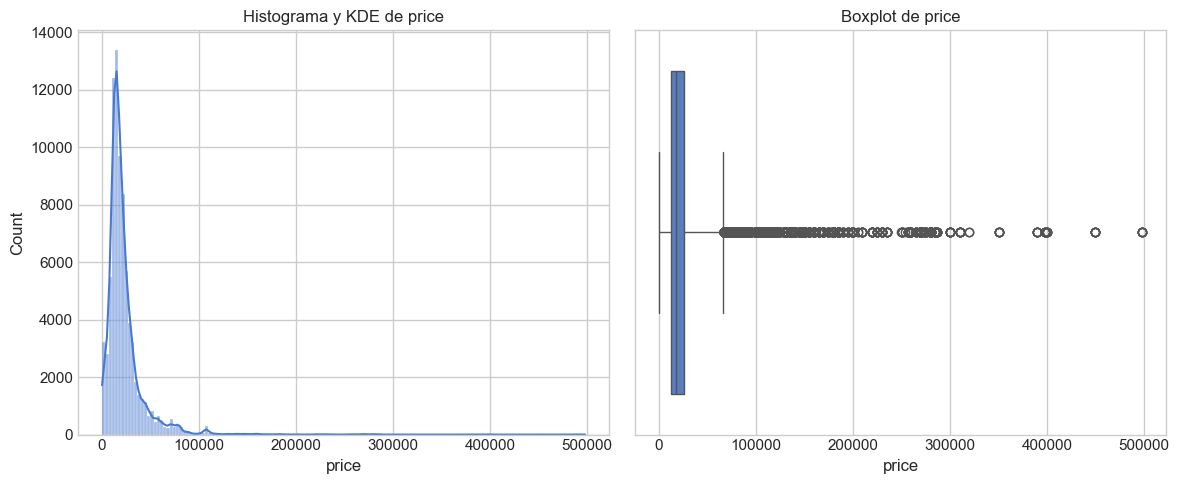

In [96]:
viz.plot_distribution_combined_graphs(train, [target], whisker_width = 3, bins = 150)

In [97]:
train[target].describe()

count     80000.000000
mean      22844.601438
std       23158.585868
min           0.000000
25%       12490.000000
50%       17450.000000
75%       25875.000000
max      498000.000000
Name: price, dtype: float64

It can be seen that the target has a long tail distribution, which we will have to take into account when modelling. We also find outliers.

We are struck by the fact that there are cars with a price of 0, which is an error or a false advertisement. Therefore, we proceed to eliminate all the rows that have a price of less than 2000€.

In [98]:
train.drop(index = (train.loc[train[target] < 2000].index), inplace = True)

We are going to see how the distribution of the target changes when we apply some transformation, we are going to try to make its distribution as normal as possible.

With a logarithmic transformation:


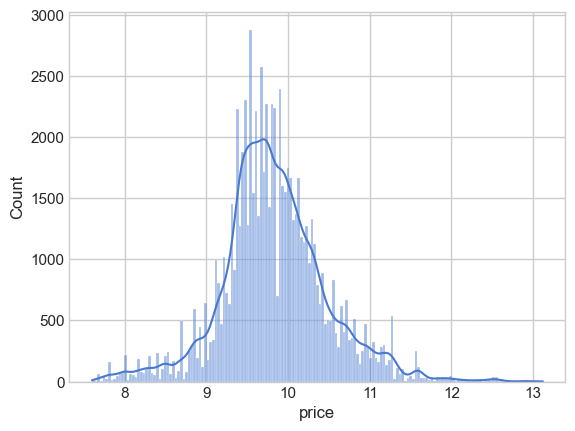

In [99]:
print('With a logarithmic transformation:')
sns.histplot(np.log(train[target]), kde = True);

Applying box-cox:


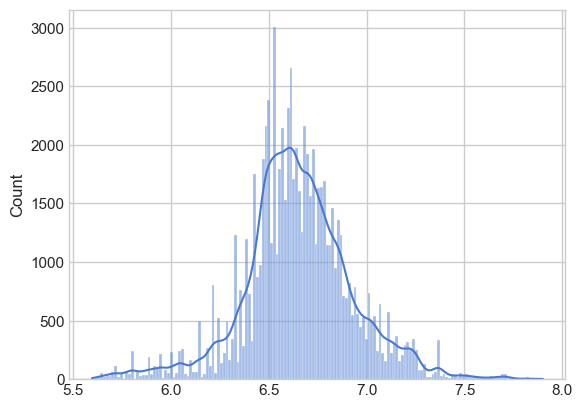

In [100]:
print('Applying box-cox:')
sns.histplot(stats.boxcox(train[target])[0], kde = True);

Both transformations bring the target closer to normal, but let's use a Q-Q plot to see which transformation suits us best.

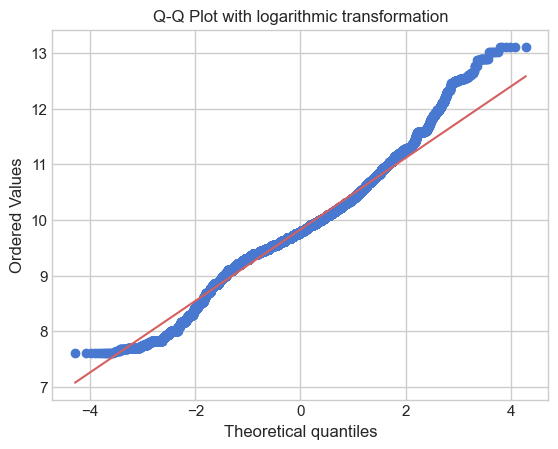

In [101]:
stats.probplot(np.log(train[target]), dist = "norm", plot = plt)
plt.title('Q-Q Plot with logarithmic transformation')
plt.show();

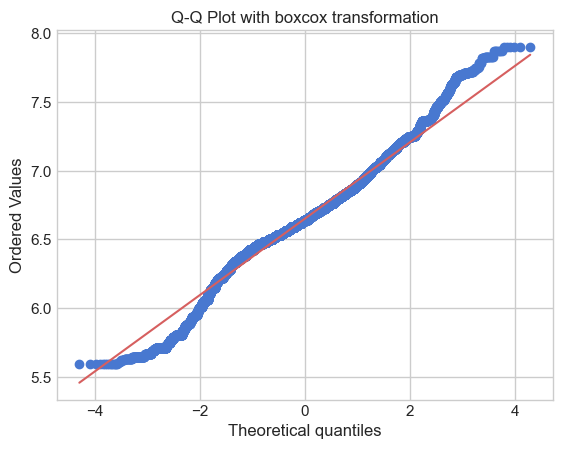

In [102]:
stats.probplot(stats.boxcox(train[target])[0], dist = "norm", plot = plt)
plt.title('Q-Q Plot with boxcox transformation')
plt.show();

The logarithmic transformation makes the distribution skew at low values, while the boxcox does so at very high values. We will use the logarithmic transformation mainly for simplicity.

## Feature selection

We are going to eliminate those variables whose % of nulls is very high and those that we have selected by looking at their description.

In [103]:
cols_to_drop = ['doors', 'color', 'description', 'vehicle_type', 'currency', 'dealer_name', 'dealer_description', \
                'dealer_address', 'dealer_city', 'dealer_country_code', 'dealer_is_professional', 'dealer_website', \
                'dealer_registered_at', 'date', 'publish_date', 'update_date', 'location', 'photos']

In [104]:
train.drop(columns = cols_to_drop, inplace = True)

In [105]:
print(f'Now whe have {len(train.columns)} columns')

Now whe have 10 columns


As the dataset comes from announcements in different applications, we have many duplicates where only the update date changes, which we have now removed. Therefore, we are now going to clean up the duplicates.

In [106]:
print(f'The number of rows originally is: {train.shape[0]}\n\
The number of rows without duplicates is: {train.drop_duplicates().shape[0]}')

The number of rows originally is: 77638
The number of rows without duplicates is: 36982


In [107]:
train.drop_duplicates(keep = 'last', inplace = True)

## Exploratory data analysis: univariate

### Numerical features

In [108]:
num_cols = []
for col in train.columns:
    if col == 'price':
        pass
    elif train[col].dtype == 'int64' or train[col].dtype == 'float64':
        num_cols.append(col)
    
print('The numerical features are:', num_cols)

The numerical features are: ['year', 'kms', 'power', 'dealer_zip_code']


(4, 2)


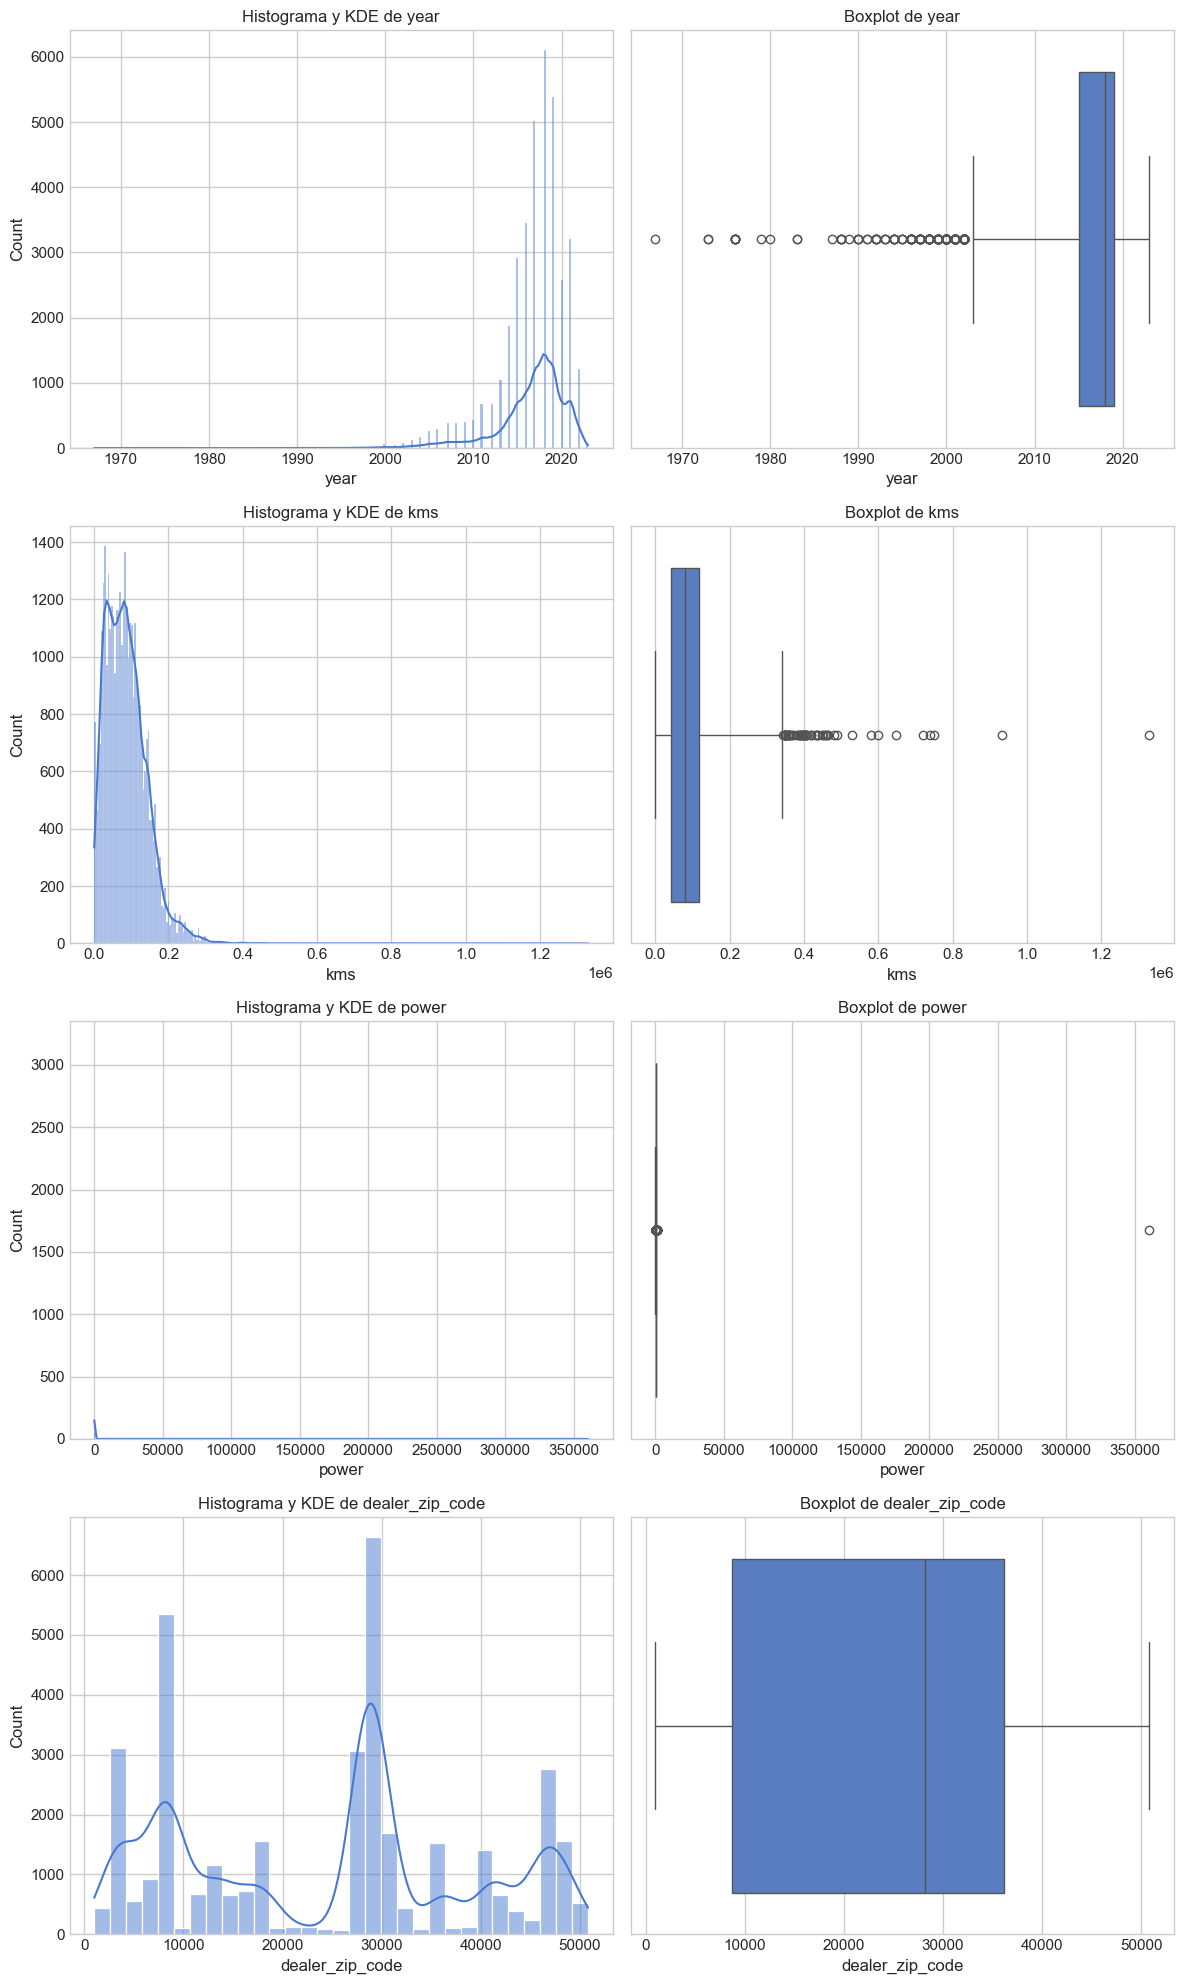

In [109]:
viz.plot_distribution_combined_graphs(train, num_cols, whisker_width = 3)

Analysing the histograms of each numerical variable, we can observe the following:
- year: it can be observed that most of the vehicles are after the year 2000, its distribution is asymmetric, so we will try to normalise it.
- kms: asymmetric distribution, most of the values are between 0 and 250,000 km, we will try to normalise it.
- power: very high values are observed for the real power of a vehicle, so there are errors. We will take a closer look at this column.
- photos: almost all ads have between 7 and 10 photos, it will be interesting to normalise.
- dealer_zip_code: the postcode is a bit more spread over the whole range of values, but we will see how normalisation suits it.

In [110]:
train[num_cols].describe()

,year,kms,power,dealer_zip_code
count,36982.000000,3.677900e+04,36905.000000,36955.000000
mean,2016.668677,8.588667e+04,154.934535,24412.650819
std,3.962608,5.629716e+04,1877.780874,14587.011044
min,1967.000000,0.000000e+00,0.000000,1002.000000
25%,2015.000000,4.271300e+04,102.000000,8734.000000
50%,2018.000000,7.939600e+04,129.000000,28230.000000
75%,2019.000000,1.176180e+05,150.000000,36164.000000
max,2023.000000,1.330000e+06,360571.000000,50820.000000


#### Power

In [111]:
train.loc[train.power < train.power.max(), 'power'].max()

np.float64(999.0)

In [112]:
train.loc[train.power > 800]

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code
40435,Tesla,Model X,Performance Ludicrous 680 5p Aut.,Eléctrico,2019,88900.0,816.0,automatic,79880,46001.0
40430,Tesla,Model X,Performance Ludicrous 680 5p Aut.,Eléctrico,2019,88900.0,816.0,automatic,79900,46001.0
11231,Dodge,Viper,SRT-10 503 2p,Gasolina,2008,3000.0,850.0,manual,279000,28803.0
40475,Tesla,Model S,Plaid 1020 100kWh Tracción Intregal 5p Aut.,Eléctrico,2023,3046.0,999.0,automatic,149990,28046.0
48803,Audi,S8,4.0 TFSI 571 quattro 4p tip.,Gasolina,2000,250000.0,360571.0,automatic,6000,2007.0
38751,Dodge,Viper,SRT DEMON,Gasolina,2008,8700.0,850.0,automatic,199000,28803.0
21312,Tesla,Model S,Performance Ludicrous 613 5p Aut.,Eléctrico,2019,45920.0,816.0,automatic,78500,46001.0


We can see that the car with 360571 hp is an error, as there is no vehicle with that power. The rest are correct, however, so we are only going to eliminate those ads with more than 1020 hp, as there is a Tesla model on the market that reaches that power.

In [113]:
train.drop(train.loc[train.power > 1020].index, inplace = True)

### Categorical features

As categorical variables we will count only fuel and shift, since make, model and version have too many categories, so we will see what to do with them later.

In [114]:
cat_cols = ['fuel', 'shift']

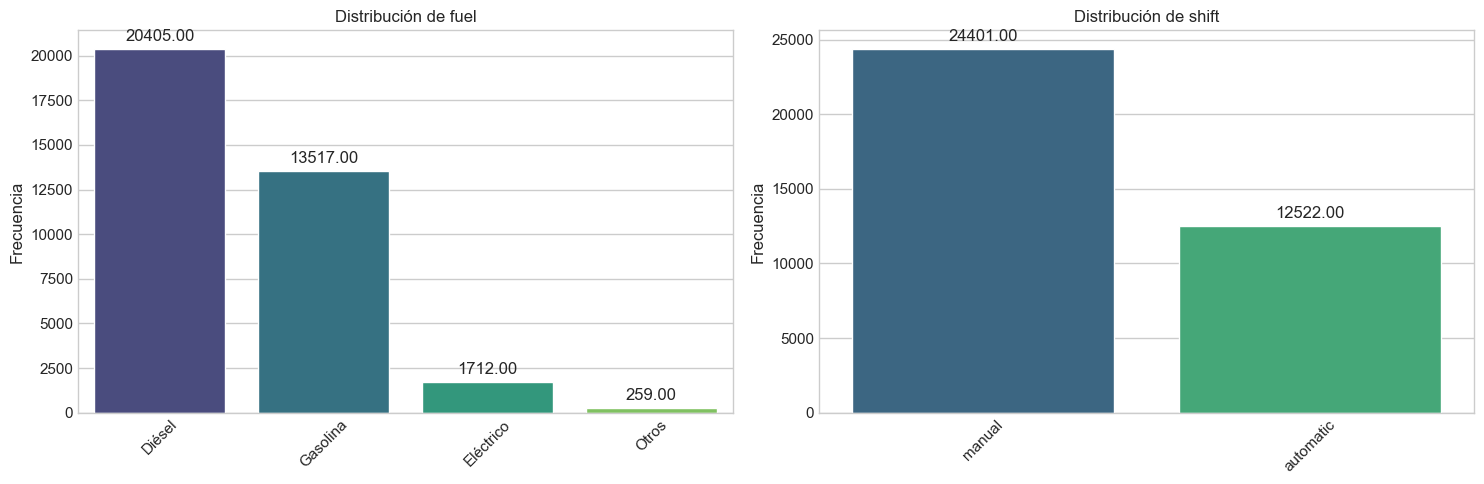

In [115]:
viz.plot_distribution_categoricas(train, cat_cols, relativa = False, mostrar_valores = True);

We did not observe anything strange, later we will do a bivariate analysis to compare the categories with the target.

As we said, the make, model and version columns, we will evaluate them in the data engineering part, to see what we can do with them and what extra information we can obtain.

## Exploratory data analysis: bivariant

### Numerical variables versus target

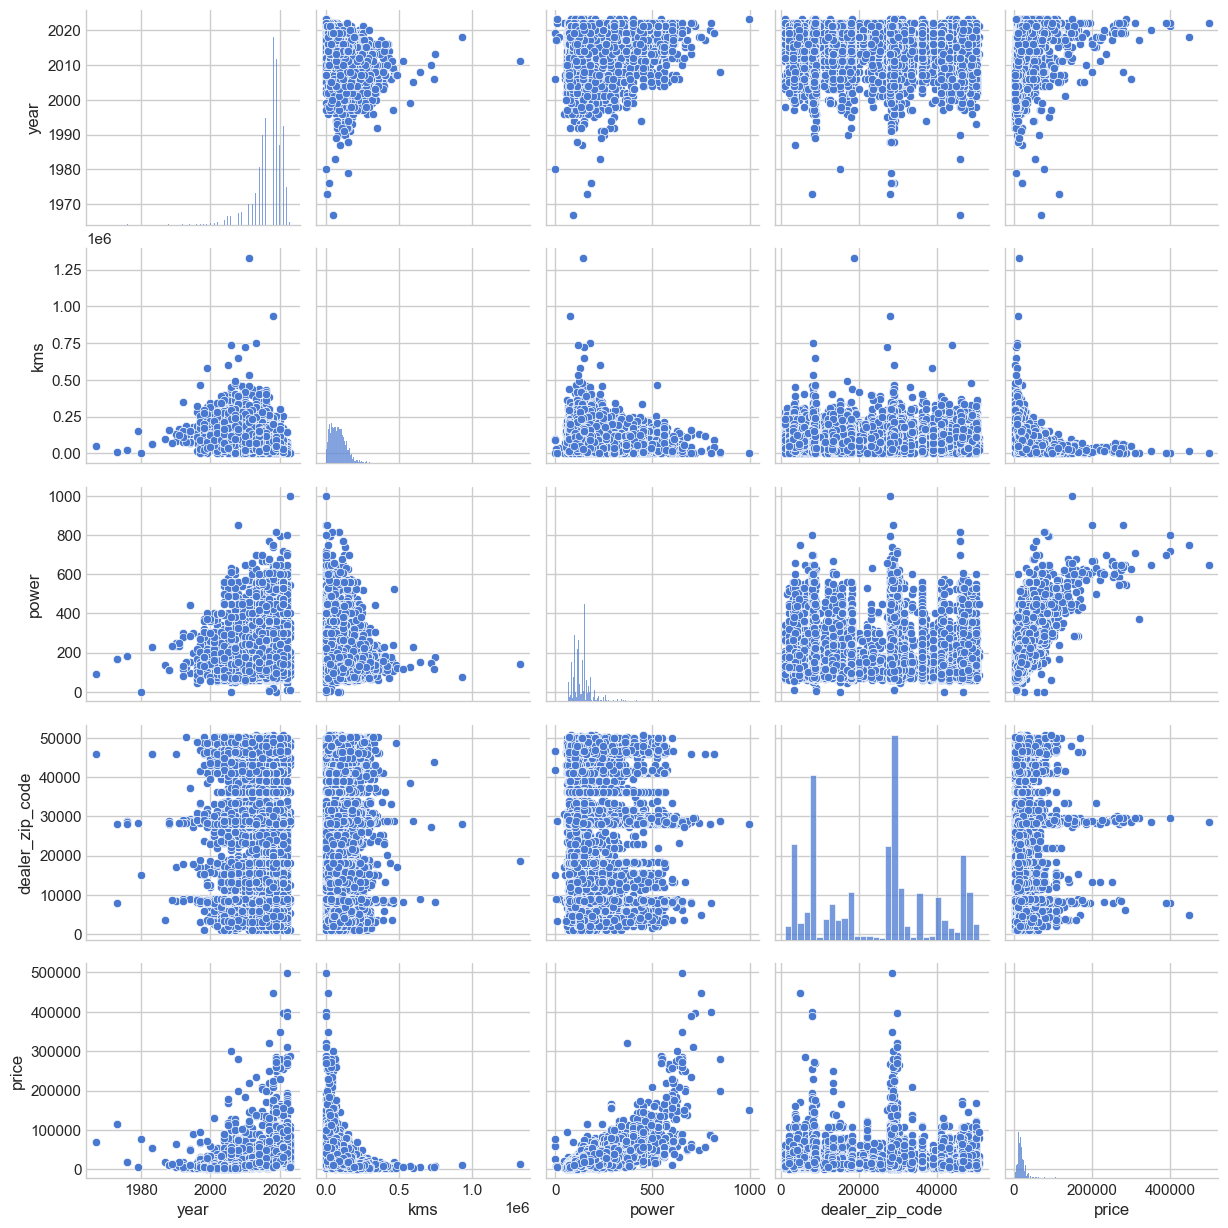

In [116]:
sns.pairplot(train[num_cols + [target]]);

Only the power variable is somewhat related to price, the rest do not seem to have much of a relationship with the price of the car.

Let's look at the correlation between the selected numerical variables and the target, to see how important they might be.

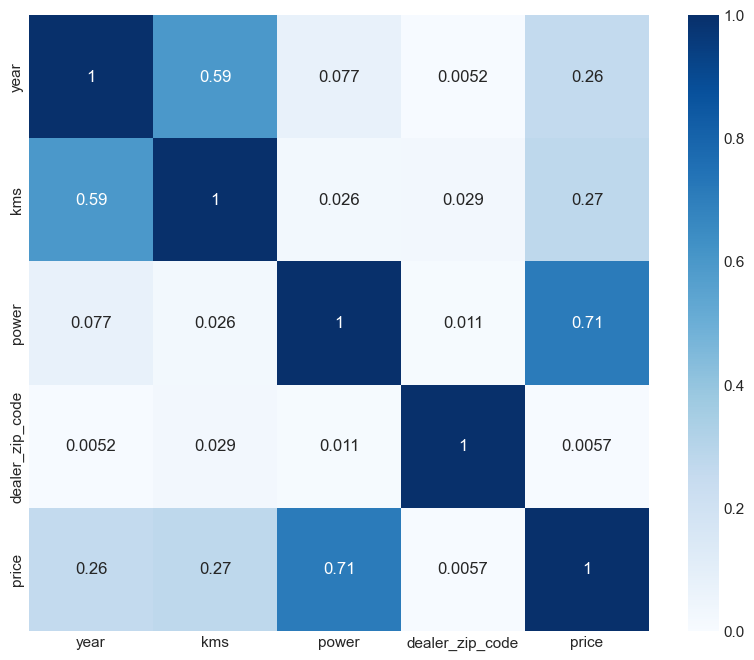

In [117]:
plt.figure(figsize = (10,8))
sns.heatmap(np.abs(train[num_cols + [target]].corr()), annot = True, cmap = 'Blues', vmin = 0, vmax = 1);

We observe a strong correlation between target and power. Year and kms also have an interesting correlation, however photos and dealer_zip_code do not seem to contribute much. We will make two lists, one with all variables and one with those that have some correlation.

In [118]:
num_feat = num_cols.copy()
num_feat_corr = ['power', 'kms', 'year']

### Categorical variables versus target

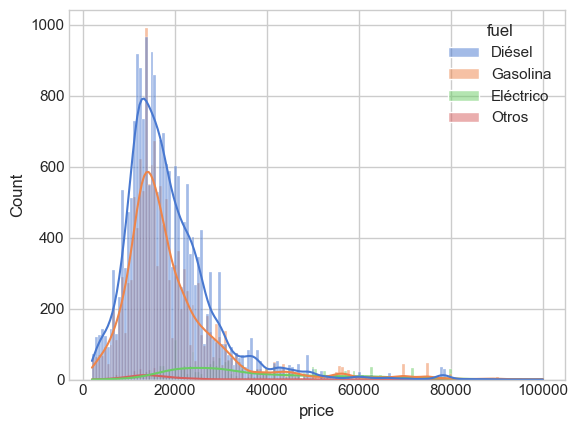

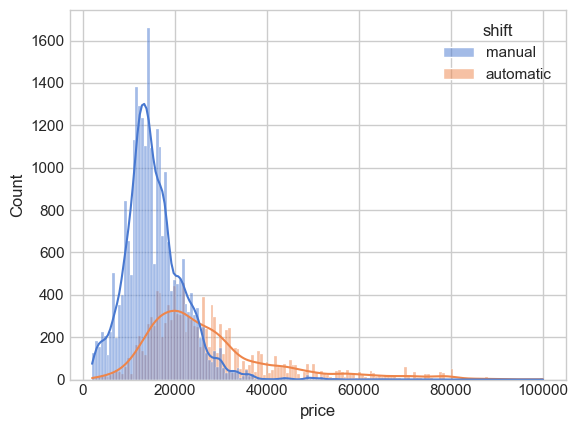

In [119]:
for col in cat_cols:
    sns.histplot(train.loc[train[target] < 100000], x = target, hue = col, kde = True)
    plt.show();

After analysing the relationship between target and categories, we can observe:
- It seems that electric cars are priced higher than fossil fuel cars.
- It seems that automatic cars are more expensive than manual cars.

Therefore, we will add both columns to our final features.

In [120]:
cat_feat = cat_cols.copy()

In addition, let's add the columns make and model to the categorical selection for the time being.

In [121]:
total_cat_feat = cat_feat + ['make', 'model']
total_cat_feat

['fuel', 'shift', 'make', 'model']

## Handling missings

Let's see how many nulls our train dataset has to see if we remove them or try to enter those missing data.

In [122]:
train.isna().sum() / len(train) * 100

make               0.000000
model              0.000000
version            0.135205
fuel               2.942051
year               0.000000
kms                0.548931
power              0.208215
shift              0.156837
price              0.000000
dealer_zip_code    0.073010
dtype: float64

We see that the following columns have missings:
- version: we are not going to remove them, because it is a column that we will probably transform and remove later.
- fuel: has 3% missings. As most of the vehicles are diesel or petrol, we will probably use the mode to fill in these gaps.
- kms: we can use the mean or median to fill them.
- power: we can use the mean or median to fill them as well.
- shift: there are more manual cars than automatic cars, we will probably fill them with the mode.
- dealer_zip_code: has very few missings, we can use the mode (it is a discrete numeric) to fill in those missings.

In [123]:
train.loc[train['fuel'].isna()]

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code
46160,Ford,Tourneo Custom,2.0 Ecoblue 96kW (130CV) Hybrid L1 Trend,NaN,2020,31649.0,130.0,manual,27990,23008.0
3132,Toyota,Corolla,1.8 125H BUSINESS E-CVT TOURING SPORT,NaN,2020,12429.0,122.0,automatic,20990,3010.0
808,Renault,Arkana,RS Line TCe 103kW(140CV) EDC MicroH.-SS,NaN,2021,19995.0,140.0,automatic,27490,41005.0
81746,Toyota,C-HR,1.8 125H Dynamic Plus,NaN,2017,55586.0,122.0,automatic,20990,36211.0
66277,Toyota,C-HR,1.8 125H Advance,NaN,2021,47306.0,122.0,automatic,22990,17007.0
...,...,...,...,...,...,...,...,...,...,...
69479,Opel,Corsa,1.4 100 Selective 3p,NaN,2012,100000.0,100.0,manual,6800,43202.0
48555,CUPRA,Leon,1.4 e-Hybrid 180kW (245CV) DSG,NaN,2020,36000.0,245.0,automatic,32990,36211.0
56886,CUPRA,Leon,1.4 e-Hybrid 180kW (245CV) DSG,NaN,2020,36000.0,245.0,automatic,32990,48004.0
5311,Citroen,C5 X,Hybrid 225 e-EAT8 Shine,NaN,2022,2.0,225.0,automatic,40950,8830.0


In the version column of cars that do not have fuel, we can get information on whether it is petrol/diesel or hybrid/electric, so we will not touch this column until we have transformed version. The same is true for power. 

However, kms, shift and dealer_zip_code can be filled in.

In [124]:
kms_mean_train = train['kms'].mean().round(0)
shift_mode_train = train['shift'].mode()[0]
dealer_zip_code_mode_train = train['dealer_zip_code'].mode()[0]

train.loc[train['kms'].isna(), 'kms'] = kms_mean_train
train.loc[train['shift'].isna(), 'shift'] = shift_mode_train
train.loc[train['dealer_zip_code'].isna(), 'dealer_zip_code'] = dealer_zip_code_mode_train

## Updating some features

We will try to extract as much information as possible from the version column that is common to all cars. We will also clean up make and model, removing unnecessary spaces and converting each string to lowercase. To do this, we are going to create different functions that will help us to do this task.

In [125]:
def extract_info(x):
    if not isinstance(x, str):
        return pd.Series([0, 0, 0])
    
    pattern = r'(?P<number>\b\d\.\d\b)[dD]?|(?P<kw>\d+)\s*kW|(?P<cv>\d+)\s*CV'
    matches = re.findall(pattern, x, re.IGNORECASE)

    cylinders_capacity = kw = cv = 0
    for match in matches:
        if match[0]:
            cylinders_capacity = float(match[0])
        if match[1]:
            kw = float(match[1])
        if match[2]:
            cv = float(match[2])
    
    return pd.Series([cylinders_capacity, kw, cv])

def lowercase_info(x):
    return x.lower().strip()

In [126]:
train[['cylinders_capacity', 'kW', 'CV']] = train['version'].apply(extract_info)
train['make'] = train['make'].apply(lowercase_info)
train['model'] = train['model'].apply(lowercase_info)

In [127]:
train.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code,cylinders_capacity,kW,CV
86979,citroen,c5,2.0 HDi 140cv Business,Diésel,2015,133690.0,140.0,manual,10290,28021.0,2.0,0.0,140.0
74932,fiat,500l,Pop Star 1.4 16v 95CV,Gasolina,2015,165699.0,95.0,manual,7990,46070.0,1.4,0.0,95.0
76079,volkswagen,polo,Advance 1.0 TSI 70kW (95CV),Gasolina,2021,56215.0,95.0,manual,16490,28021.0,1.0,70.0,95.0
98989,citroen,c4 picasso,BlueHDi 120cv EAT6 Live Edition,Diésel,2016,128108.0,120.0,automatic,12990,18005.0,0.0,0.0,120.0
21915,fiat,500,1.2 51 kW (69 CV) S Dualogic,Gasolina,2017,95000.0,69.0,automatic,10900,11140.0,1.2,51.0,69.0


#### Power

In [128]:
train.loc[train['power'].isna(), 'power'] = train.loc[train['power'].isna(), 'CV']

In [129]:
train.loc[train['power'] < 1]

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code,cylinders_capacity,kW,CV
51219,peugeot,107,1.0i Urban,Gasolina,2010,199000.0,0.0,manual,4990,8028.0,0.0,0.0,0.0
1088,renault,clio,Confort Dynamique 1.4 16v,Gasolina,2006,113000.0,0.0,manual,4990,8028.0,1.4,0.0,0.0
1647,tesla,model s,75D 5p Aut.,Eléctrico,2019,87000.0,0.0,automatic,59900,46600.0,0.0,0.0,0.0
58290,mercedes-benz,clase s,280S,Gasolina,1979,151862.0,0.0,manual,6000,28294.0,0.0,0.0,0.0
90556,citroen,c3,C3 1.4 COOL,Gasolina,2009,61416.0,0.0,manual,6990,46600.0,1.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94088,citroen,berlingo,1.6 BLUEHDI LARGA 3PLAZAS 100,Diésel,2018,149638.0,0.0,manual,10990,36204.0,1.6,0.0,0.0
4425,alpine,a110,1100,Gasolina,1980,0.0,0.0,manual,77000,15141.0,0.0,0.0,0.0
55609,lexus,rx,RX450H LUXURY,NaN,2015,270000.0,0.0,automatic,19990,8028.0,0.0,0.0,0.0
32635,subaru,impreza,1.6i-S CVT AWD,Gasolina,2018,89182.0,0.0,automatic,17995,46020.0,0.0,0.0,0.0


Now the nulls have been transformed into 0.0, but we can still get some more power from some cars by using the kW. We will use the kW for those we can and apply the rounded average to the rest.

In [130]:
train.loc[train['power'] == 0, 'power'] = train.loc[train['power'] == 0, 'kW']

power_mean_train = train['power'].mean().round(0)
train.loc[train['power'] == 0, 'power'] = power_mean_train

The power column no longer has any missing value.

#### Fuel y version

We are going to leave the version column with null, as we are not going to use it to train our model. However, we have not obtained information on the type of fuel used by the vehicles when decomposing the version column. Therefore, we are going to use fashion to fill in the nulls in fuel.

In [131]:
fuel_mode_train = train['fuel'].mode()[0]
train.loc[train['fuel'].isna(), 'fuel'] = fuel_mode_train

In addition, we will remove the kW and hp columns, as they will no longer be used.

In [132]:
train.drop(columns = ['kW', 'CV'], inplace = True)

### New features

#### power_cat
As we already have the power of all vehicles, we can classify them according to their power.

In [133]:
def power_classify(power):
    if power < 100:
        return 'Baja'
    elif power < 150:
        return 'Media'
    elif power < 200:
        return 'Alta'
    else:
        return 'Muy Alta'

In [134]:
train['power_cat'] = train['power'].apply(power_classify)

#### Ratio kms_years

We can roughly establish vehicle wear and tear by dividing the car's mileage by the number of years since registration. The data is up to 2023, so we will use 2024 as a guide.

In [135]:
actual_year = 2024

train['kms_years'] = train.apply(lambda row: row['kms'] / (actual_year - row['year']), axis = 1)

#### Environmental label

In the second-hand car market in Spain, a very important variable is the environmental label of the car, as depending on this label, the car can access or not to different cities or areas. This label depends on the year of registration and the type of fuel, being:
- A (no label): petrol before 2001 and diesel before 2006.
- B: petrol 2001 to 2006 and diesel 2006 to 2015
- C: petrol from 2006 onwards and diesel from 2015 onwards
- ECO: hybrid cars
- ZERO: electric cars

In [136]:
filter_A = ((train['year'] < 2001) & (train['fuel'] == 'Gasolina')) | ((train['year'] < 2006) & (train['fuel'] == 'Diésel'))
filter_B = ((train['year'] >= 2001) & (train['year'] < 2006) & (train['fuel'] == 'Gasolina')) | ((train['year'] >= 2006) & (train['year'] < 2015) & (train['fuel'] == 'Diésel'))
filter_C = ((train['year'] >= 2006) & (train['fuel'] == 'Gasolina')) | ((train['year'] >= 2015) & (train['fuel'] == 'Diésel'))
filter_ZERO = (train['fuel'] == 'Eléctrico')
filter_otros = train['fuel'] == 'Otros'

In [137]:
train.loc[filter_A, 'emission_label'] = 'A'
train.loc[filter_B, 'emission_label'] = 'B'
train.loc[filter_C, 'emission_label'] = 'C'
train.loc[filter_ZERO, 'emission_label'] = 'ZERO'
train.loc[filter_otros, 'emission_label'] = train['emission_label'].mode()[0]

In [138]:
train.emission_label.value_counts()

emission_label
C       29956
B        4761
ZERO     1712
A         552
Name: count, dtype: int64

We note that most cars are labelled C. We will assess later whether this could be an interesting variable.

In [139]:
train.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code,cylinders_capacity,power_cat,kms_years,emission_label
86979,citroen,c5,2.0 HDi 140cv Business,Diésel,2015,133690.0,140.0,manual,10290,28021.0,2.0,Media,14854.444444,C
74932,fiat,500l,Pop Star 1.4 16v 95CV,Gasolina,2015,165699.0,95.0,manual,7990,46070.0,1.4,Baja,18411.000000,C
76079,volkswagen,polo,Advance 1.0 TSI 70kW (95CV),Gasolina,2021,56215.0,95.0,manual,16490,28021.0,1.0,Baja,18738.333333,C
98989,citroen,c4 picasso,BlueHDi 120cv EAT6 Live Edition,Diésel,2016,128108.0,120.0,automatic,12990,18005.0,0.0,Media,16013.500000,C
21915,fiat,500,1.2 51 kW (69 CV) S Dualogic,Gasolina,2017,95000.0,69.0,automatic,10900,11140.0,1.2,Baja,13571.428571,C


## Exploratory data analysis: new features

We proceed to see what information the new variables obtained from the existing columns give us from the beginning.

### Numerical features

In [140]:
new_num_cols = ['cylinders_capacity', 'kms_years']

(2, 2)


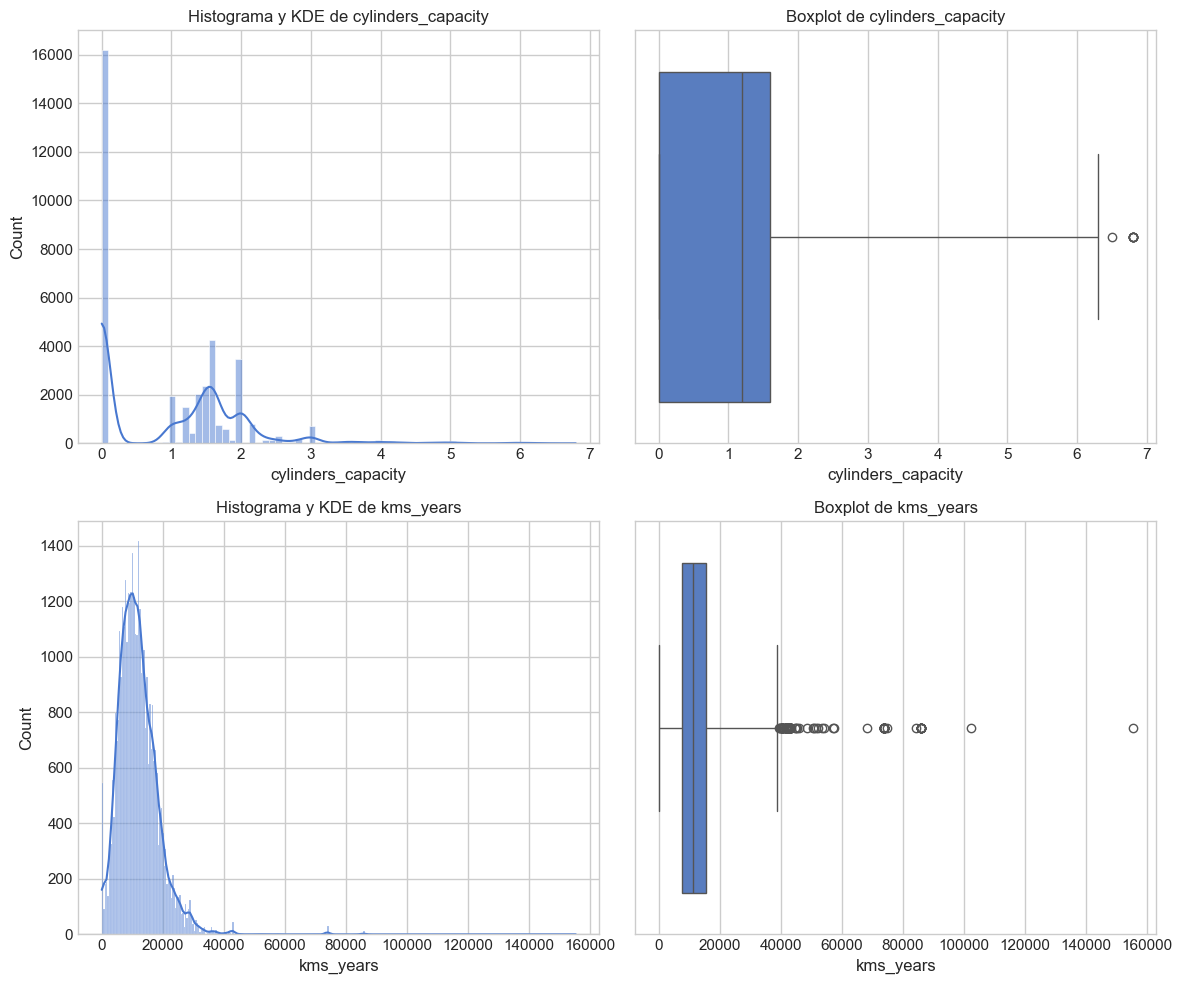

In [141]:
viz.plot_distribution_combined_graphs(train, new_num_cols, whisker_width = 3)

We can observe:
- In cylinders_capacity there are two main categories: 0 indicating that we do not know the displacement and > 0 indicating that we do know the displacement, we will have to take this into account.
- The ratio kms_years has several outliers that we will have to deal with in case of bad results with our model.

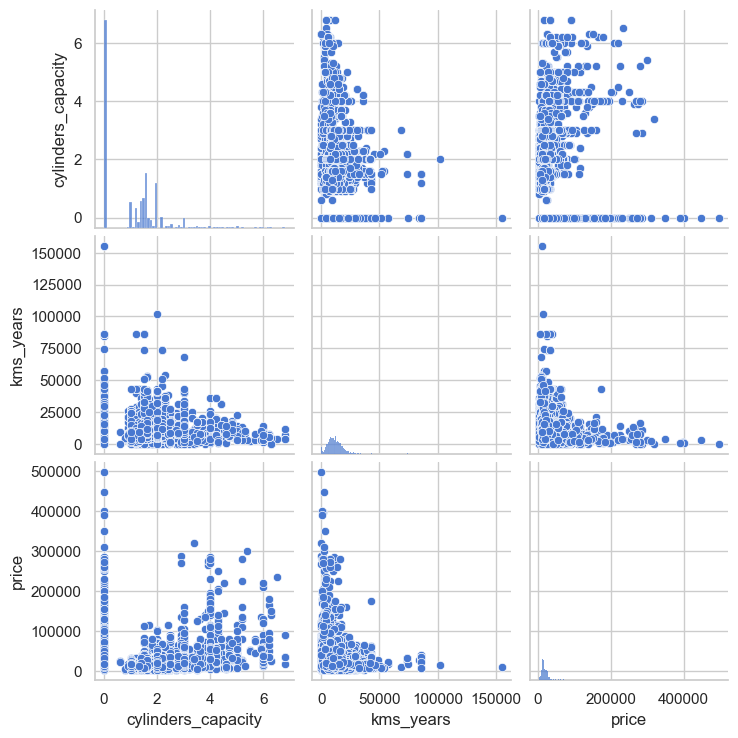

In [63]:
sns.pairplot(train[new_num_cols + [target]]);

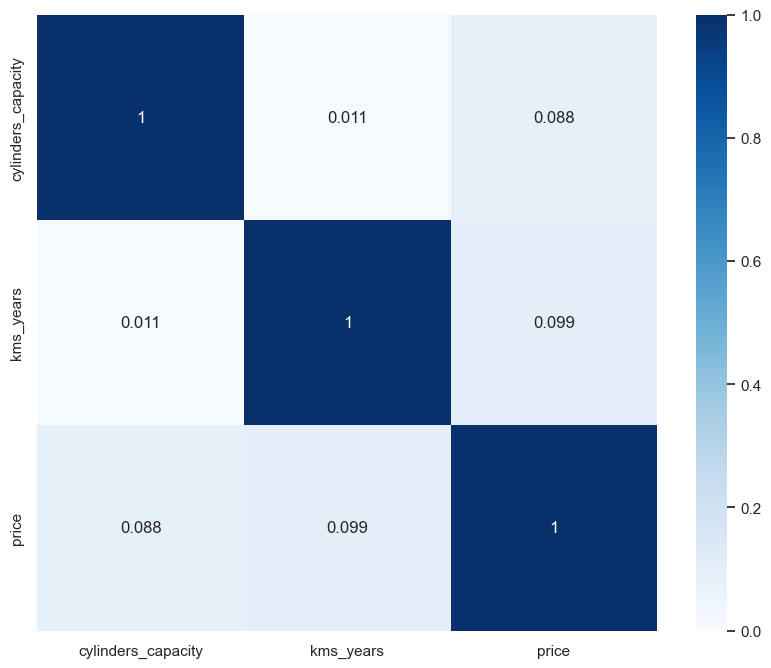

In [64]:
plt.figure(figsize = (10,8))
sns.heatmap(np.abs(train[new_num_cols + [target]].corr()), annot = True, cmap = 'Blues', vmin = 0, vmax = 1);

Visualising the relationship between these new variables and the price, we do not find too much correlation. Therefore, we will add only kms_years to the correlation selection and both to the overall selection.

In [142]:
num_feat.append('cylinders_capacity')
num_feat.append('kms_years')
num_feat_corr.append('kms_years')

### Categorical features

In [143]:
new_cat_cols = ['power_cat', 'emission_label']

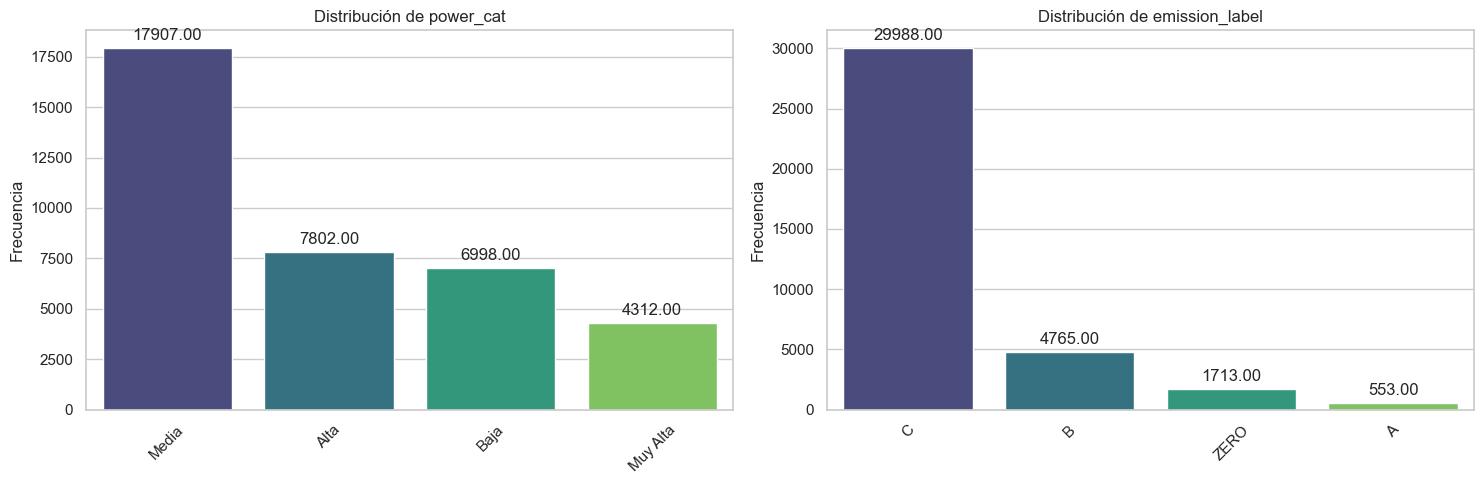

In [67]:
viz.plot_distribution_categoricas(train, new_cat_cols, relativa = False, mostrar_valores = True);

We note the following:
- Most of the vehicles have medium power, i.e. between 100 and 150 hp.
- Most of the vehicles have a C label.

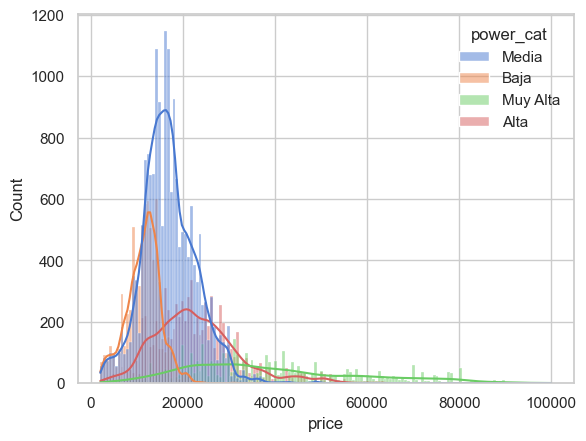

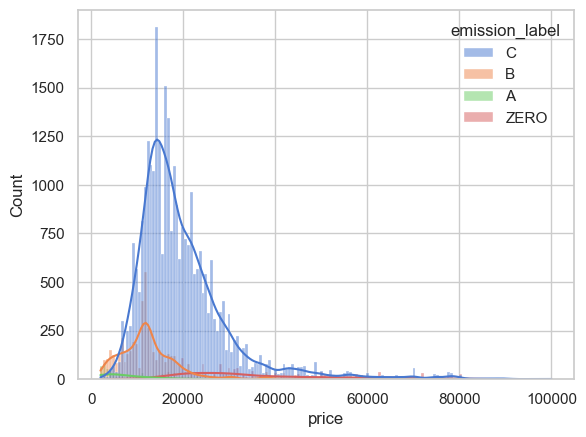

In [68]:
for col in new_cat_cols:
    sns.histplot(train.loc[train[target] < 100000], x = target, hue = col, kde = True)
    plt.show();

Power categorisation does differentiate in price and it seems that the environmental label is also important, so we will include both.

In [144]:
total_cat_feat.append('power_cat')
total_cat_feat.append('emission_label')

## Transformation of test data

Next, we will perform these same transformations on the test dataset.

In [145]:
# Remove columns that are not needed:
test.drop(columns = cols_to_drop, inplace = True)

# Remove vehicles with a value lower than 2000, as they are likely dismantled parts or fake listings:
test.drop(index = (test.loc[test[target] < 2000].index), inplace = True)

# Remove duplicates:
test.drop_duplicates(keep = 'last', inplace = True)

# Remove records with power greater than 1020, as they are errors:
test.drop(test.loc[test.power > 1020].index, inplace = True)

# Fill missing values with the mean and modes used in train:
test.loc[test['kms'].isna(), 'kms'] = kms_mean_train
test.loc[test['shift'].isna(), 'shift'] = shift_mode_train
test.loc[test['dealer_zip_code'].isna(), 'dealer_zip_code'] = dealer_zip_code_mode_train

# Extract as much information as possible from the 'version' column and clean 'make' and 'model':
test[['cylinders_capacity', 'kW', 'CV']] = test['version'].apply(extract_info)
test['make'] = test['make'].apply(lowercase_info)
test['model'] = test['model'].apply(lowercase_info)

# Fill missing power values using the extracted information from 'version':
test.loc[test['power'].isna(), 'power'] = test.loc[test['power'].isna(), 'CV']
test.loc[test['power'] == 0, 'power'] = test.loc[test['power'] == 0, 'kW']
test.loc[test['power'] == 0, 'power'] = power_mean_train

# Fill missing fuel values using the mode from train:
test.loc[test['fuel'].isna(), 'fuel'] = fuel_mode_train

# Remove 'kW' and 'CV' columns:
test.drop(columns = ['kW', 'CV'], inplace = True)

# Create 'power_cat' and 'kms_years' variables:
test['power_cat'] = test['power'].apply(power_classify)
test['kms_years'] = test.apply(lambda row: row['kms'] / (actual_year - row['year']), axis = 1)

# Create 'emission_label' variable:
filter_A_test = ((test['year'] < 2001) & (test['fuel'] == 'Gasoline')) | ((test['year'] < 2006) & (test['fuel'] == 'Diesel'))
filter_B_test = ((test['year'] >= 2001) & (test['year'] < 2006) & (test['fuel'] == 'Gasoline')) | ((test['year'] >= 2006) & (test['year'] < 2015) & (test['fuel'] == 'Diesel'))
filter_C_test = ((test['year'] >= 2006) & (test['fuel'] == 'Gasoline')) | ((test['year'] >= 2015) & (test['fuel'] == 'Diesel'))
filter_ZERO_test = (test['fuel'] == 'Electric')
filter_others_test = test['fuel'] == 'Others'
test.loc[filter_A_test, 'emission_label'] = 'A'
test.loc[filter_B_test, 'emission_label'] = 'B'
test.loc[filter_C_test, 'emission_label'] = 'C'
test.loc[filter_ZERO_test, 'emission_label'] = 'ZERO'
test.loc[filter_others_test, 'emission_label'] = train['emission_label'].mode()[0]

In [146]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15207 entries, 75721 to 42410
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                15207 non-null  object 
 1   model               15207 non-null  object 
 2   version             15183 non-null  object 
 3   fuel                15207 non-null  object 
 4   year                15207 non-null  int64  
 5   kms                 15207 non-null  float64
 6   power               15207 non-null  float64
 7   shift               15207 non-null  object 
 8   price               15207 non-null  int64  
 9   dealer_zip_code     15207 non-null  float64
 10  cylinders_capacity  15207 non-null  float64
 11  power_cat           15207 non-null  object 
 12  kms_years           15207 non-null  float64
 13  emission_label      0 non-null      object 
dtypes: float64(5), int64(2), object(7)
memory usage: 1.7+ MB


We already have both train and test transformed initially. Now let's prepare all that data to train our regression models.

## X_train, y_train and X_test, y_test split

In [147]:
X_train = train.drop(columns = [target, 'version'])
y_train = train[target]

X_test = test.drop(columns = [target, 'version'])
y_test = test[target]

## Preparation of variables

### Numerical

First, we are going to transform the variables using a log to see if we can normalise their distribution. And then, we proceed to scale all the numerics with MinMaxScaler, so that all the values are between 0 and 1 (just like the OneHotEncoder). The scaling is done because we will later use a linear regression model.

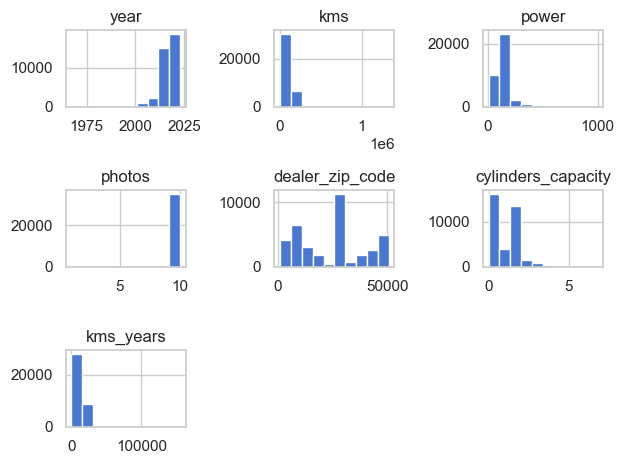

In [73]:
X_train[num_feat].hist()
plt.tight_layout()

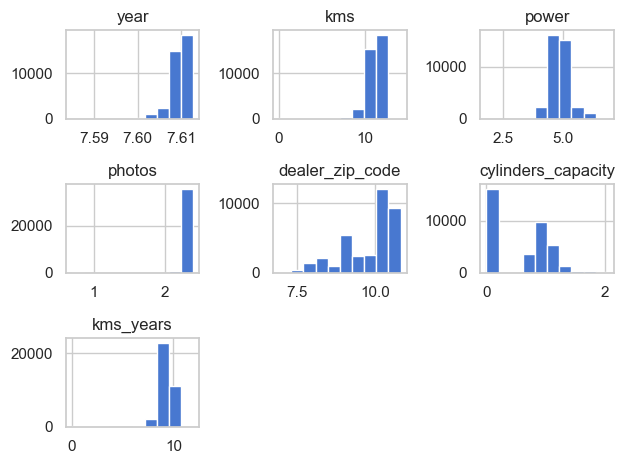

In [74]:
X_train[num_feat].apply(np.log1p).hist()
plt.tight_layout();

Excluding year and photos, we will transform the rest of the variables.

In [148]:
cols_to_log = num_feat.copy()
cols_to_log.remove('year')

In [149]:
log_transformer = FunctionTransformer(func = np.log1p)

num_pipeline = Pipeline([
    ("log", log_transformer)])

### Categorical

We are going to use ScikitLearn's One Hot Encoder to transform the categorical variables and the make and model variables. Later on we will consider using it with the version variables.

In [150]:
cat_pipeline = Pipeline([
    ("ohencoder", OneHotEncoder(handle_unknown = "ignore"))])

### Complete preprocessing

In [151]:
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, total_cat_feat),
        ("log", num_pipeline, cols_to_log)],
        remainder = "passthrough")

In [152]:
X_train = preprocessing.fit_transform(X_train)
print('The final dimensions of X_train are:', X_train.shape)

The final dimensions of X_train are: (36981, 810)


#### Aplicamos las mismas transformaciones a X_test

In [153]:
X_test = preprocessing.transform(X_test)
print('The final dimensions of X_test are::', X_test.shape)

The final dimensions of X_test are:: (15207, 810)


## Training the model

After performing different tests on other notebooks, we decided to:
- Use a RandomForestRegressor.
- Do not transform the target, as it does not improve the error.
- Use the following columns as features: [‘make’, ‘model’, ‘fuel’, ‘year’, ‘kms’, ‘power’, ‘shift’,
       ‘photos’, ‘price’, ‘dealer_zip_code’, ‘cylinders_capacity’, ‘power_cat’,
       ‘kms_years’, ‘emission_label’]
- Do not scale the variables, since it is not necessary as it is a decision tree-based model.

In [154]:
rf_reg = RandomForestRegressor(n_estimators = 200,
                               min_samples_split = 2,
                               min_samples_leaf = 1,
                               max_features = 'sqrt',
                               max_depth = None,
                               bootstrap = False,
                               random_state = 42)

rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=200,
                      random_state=42)

## Test evaluation

Let's test our trained and optimised model against test.

In [159]:
y_pred = rf_reg.predict(X_test)

In [160]:
print('TEST ERROR')
print('----------')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

TEST ERROR
----------
RMSE: 4005.1997659165695
R2: 0.9601615081791322


Save the model in the models folder

In [84]:
# joblib.dump(rf_reg, cm.MODEL_SAVE_PATH)

## Error analysis

We compare the predicted and actual values in a graph.

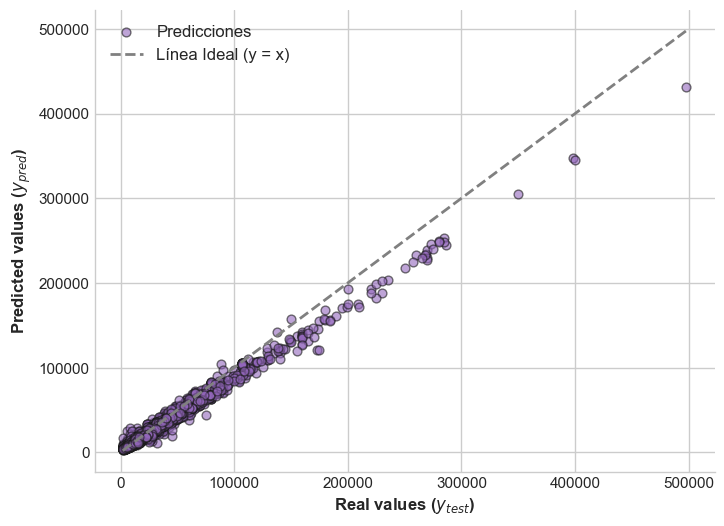

In [161]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha = 0.6, color = '#9467bd', edgecolors = 'k', s = 40, label = 'Predicciones')  

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'gray', linestyle = '--', linewidth = 2, label = 'Línea Ideal (y = x)')

plt.xlabel('Real values ($y_{test}$)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted values ($y_{pred}$)', fontsize=12, fontweight='bold')

plt.legend(frameon = False, fontsize = 12, loc = 'upper left')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

We show the residual, the difference between our predictions and the actual value.


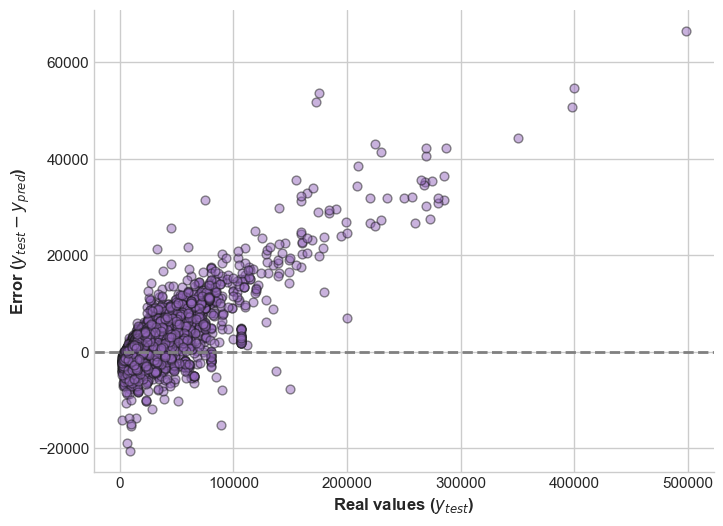

In [162]:
plt.figure(figsize = (8, 6))

plt.scatter(y_test, y_test - y_pred, alpha = 0.5, color = '#9467bd', edgecolors = 'k', s = 40)

plt.axhline(y = 0, color = 'gray', linestyle = '--', linewidth = 2)

plt.xlabel('Real values ($y_{test}$)', fontsize = 12, fontweight = 'bold')
plt.ylabel('Error ($y_{test} - y_{pred}$)', fontsize = 12, fontweight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

As we can see in both graphs, there are errors to be taken into account from very low prices up to prices of 50,000€. This could be improved by training a specific model for low-end cars, segmenting the prediction according to the vehicle category.

It would also be interesting to evaluate those errors that exceed €10,000, to see what type of vehicles or what data could be generating this confusion. 

## Conclusions

The error against test of our optimised model meets expectations. 

However, it would be interesting to propose different models depending on the range of the vehicle or the type of vehicle. This would require more data, for example by asking for more information about the car in the advertisements. In this way, we would get closer to the right price at the current moment of the car market.

                                                                                    | Mariano Puchades del Olmo |                                                                                            